In [1]:
from deep_traffic_generation.HVAE_Generation import TwoStageVAE
from traffic.algorithms.generation import Generation
from deep_traffic_generation.core.datasets import TrafficDataset

from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
from os import walk

# Dataset

In [2]:
dataset = TrafficDataset.from_file(
    # "../../deep_traffic_generation/data/traffic_noga_tilFAF_train_enriched.pkl",
    "../../deep_traffic_generation/data/traffic_noga_tilFAF_train.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

# Reconstruction

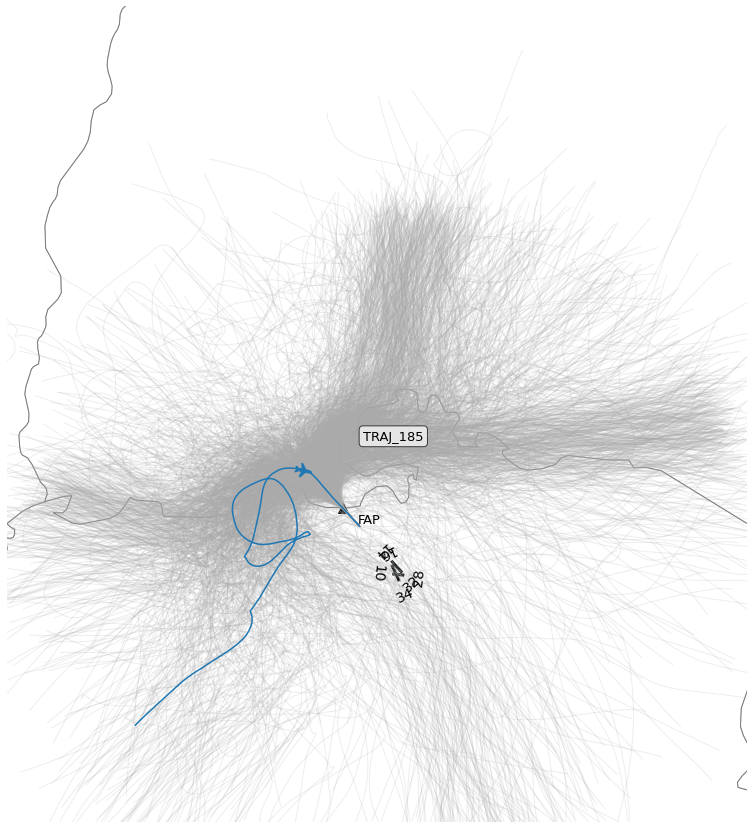

In [4]:
import matplotlib.pyplot as plt
from traffic.core.projection import EuroPP
from traffic.drawing import countries
from traffic.data import navaids
from traffic.data import airports

path = "../../deep_traffic_generation/lightning_logs/tchvae/version_2/"

t = TwoStageVAE(X = dataset, sim_type = "generation")
t.load(path, dataset.parameters)
g = Generation(generation=t, features = t.VAE.hparams.features, scaler=dataset.scaler) #scaler of the first stage (the global scaler)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15), subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries())
    ax.figure

    ax.set_extent((7.5, 9.5, 47, 48.5))

    traf = g.sample(2000, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False) #coordinates sont les coordonnées du dernier point car forward = False
    traf.plot(ax, alpha=0.2)

    k =  np.random.randint(len(traf))
    # k = 9720
    traf[k].plot(ax, color="#1f77b4", lw=1.5)
    traf[k].at_ratio(0.85).plot(
        ax,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )
    
    navaids["OSNEM"].plot(
        ax,
        zorder=2,
        marker="^",
        shift=dict(units="dots", x=15, y=-15),
        text_kw={
            "s": "FAP",
        },
    )

# Latent Space

In [5]:
path = "../../deep_traffic_generation/lightning_logs/tchvae/version_1/"

t = TwoStageVAE(X = dataset, sim_type = "generation")
t.load(path, dataset.parameters)
g = Generation(generation=t, features = t.VAE.hparams.features, scaler=dataset.scaler) #scaler of the first stage (the global scaler)

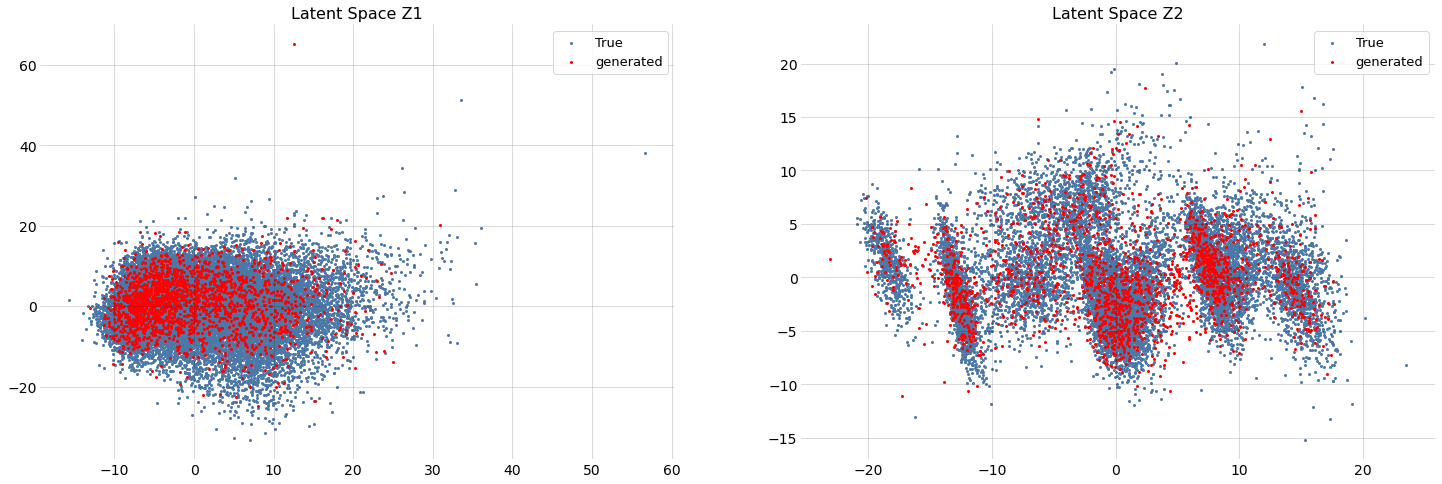

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#latent spaces of the single stage VAE, and N generated points within (the last N rows of the array)
#plot latent representation of the dataset used to initialized the SingleStageVAE object
n_gen = 2000
Z2, Z1 = t.latent_space(n_gen)

#Only fitted on train data
pca2 = PCA(n_components=2).fit(Z2[:-n_gen])
Z_embedded2 = pca2.transform(Z2)

pca1 = PCA(n_components=2).fit(Z1[:-n_gen])
Z_embedded1 = pca1.transform(Z1)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1,2, figsize=(25, 8))

    ax[0].scatter(Z_embedded1[:-n_gen, 0], Z_embedded1[:-n_gen, 1], s=4, label = "True")
    ax[0].scatter(Z_embedded1[-n_gen:, 0], Z_embedded1[-n_gen:, 1], s=4, c='red', label = "generated")
    ax[0].title.set_text("Latent Space Z1")
    ax[0].legend()

    ax[1].scatter(Z_embedded2[:-n_gen, 0], Z_embedded2[:-n_gen, 1], s=4, label = "True")
    ax[1].scatter(Z_embedded2[-n_gen:, 0], Z_embedded2[-n_gen:, 1], s=4, c='red', label = "generated")
    ax[1].title.set_text("Latent Space Z2")
    ax[1].legend()

    plt.show()

# Pseudo-inputs

In [7]:
#Computing the pseudo inputs

#Vampprior
pseudo_X = t.VAE.lsr.pseudo_inputs_NN(t.VAE.lsr.idle_input) 
pseudo_X = pseudo_X.view((pseudo_X.shape[0], 4, 200))

pseudo_h2 = t.VAE.encoder_z2(pseudo_X)
pseudo_means = t.VAE.lsr.z_loc(pseudo_h2)
pseudo_scales = (t.VAE.lsr.z_log_var(pseudo_h2) / 2).exp()

  80% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━ 804/1,000  [ 0:00:02 < 0:00:01 , 294 it/s ]

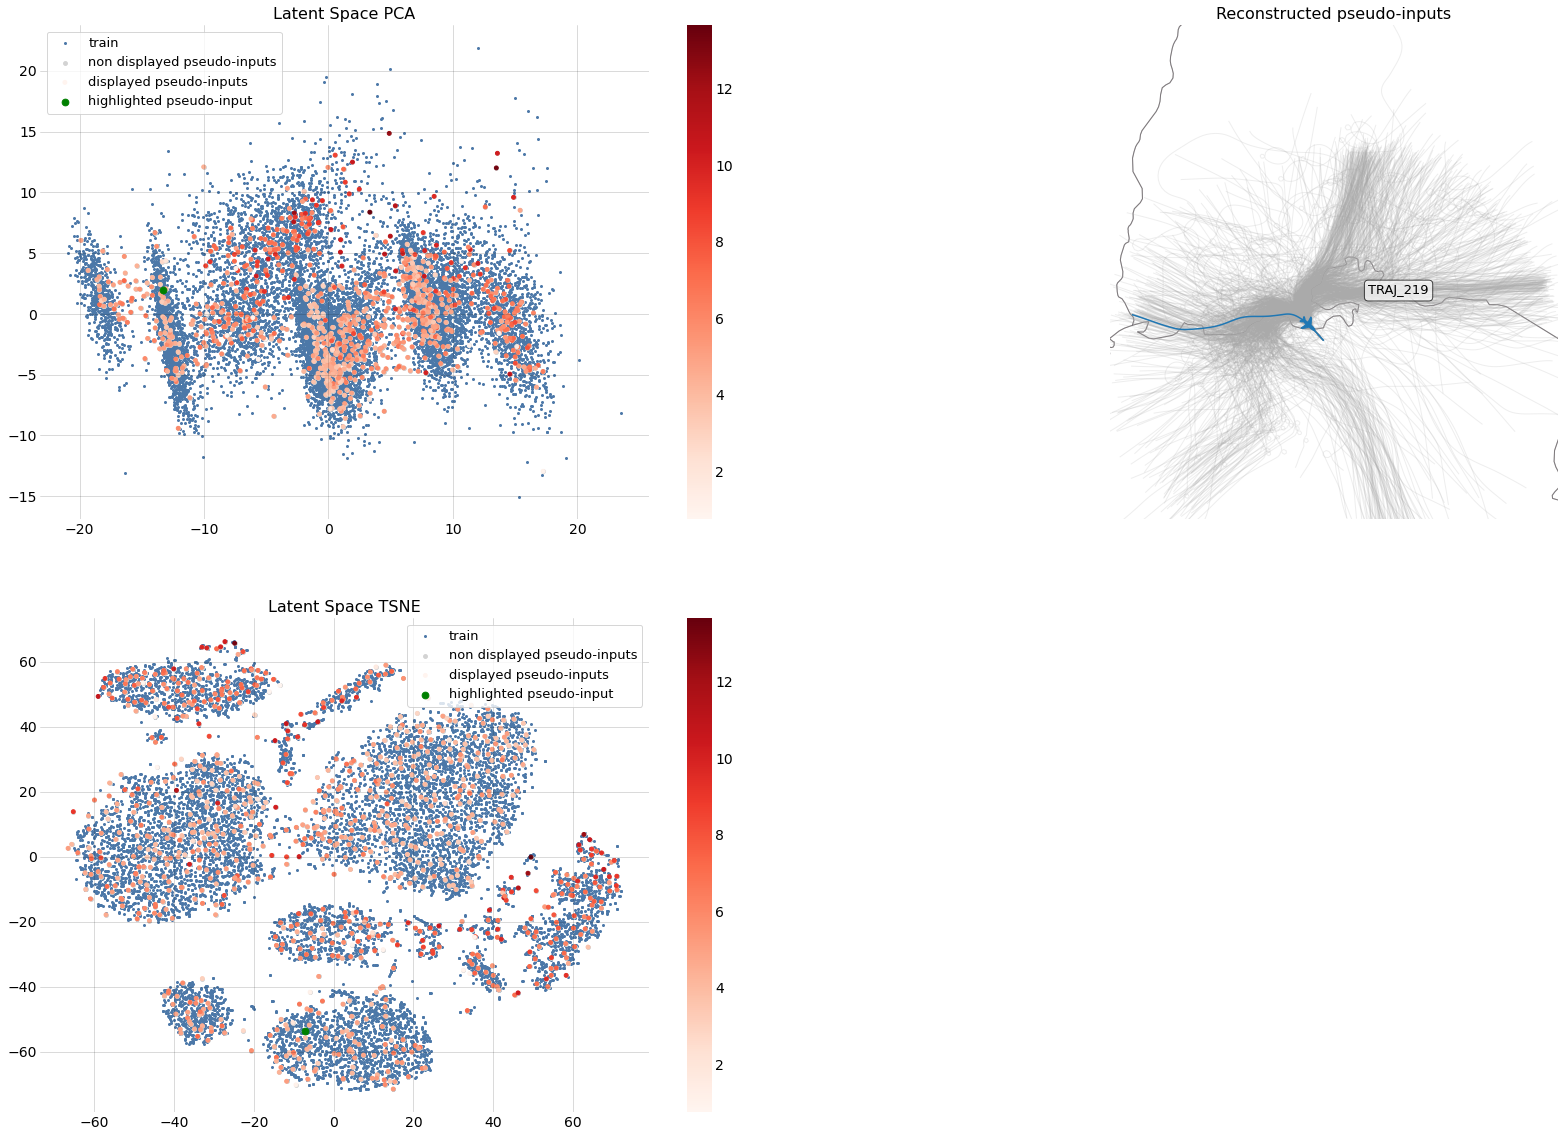

In [8]:
#Plot of the reconstructed pseudo-inputs
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from traffic.core.projection import EuroPP
from traffic.drawing import countries
from scipy.signal import savgol_filter

#Reconstructed pseudo-inputs
out = t.decode(pseudo_means)
#Neural net don't predict exaclty timedelta = 0 for the first observation
out[:,3] = 0
#The track prediction is filtered (smoothen trajectories)
out[:,0::4] = savgol_filter(out[:,0::4], 11, 3)
out_traf = g.build_traffic(out, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

#loops
def simple(flight):
    return flight.assign(simple=lambda x: flight.shape.is_simple)
out_traf = out_traf.iterate_lazy().pipe(simple).eval(desc ="")
# out_traf = out_traf.query("simple")

#latent spaces from train dataset and pseudo_inputs
Z2, _ = t.latent_space(1)
z2_train = Z2

Z = np.concatenate((z2_train, pseudo_means.detach().numpy()), axis=0)
Z_embedded1 = TSNE(n_components=2).fit_transform(Z)

pca = PCA(n_components=2).fit(Z[:-len(pseudo_means)])
Z_embedded2 = pca.transform(Z)

#col depending on the scales
# col = torch.norm(pseudo_scales, dim = 1, p = float("inf")).detach().numpy()
col = torch.norm(pseudo_scales, dim = 1, p = 2).detach().numpy()

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 20))
    ax0 = fig.add_subplot(221)
    ax1 = fig.add_subplot(222, projection=EuroPP())
    ax2 = fig.add_subplot(223)

    fidx = list(map(lambda x: int(x.split("_")[1]),out_traf.flight_ids))
    k = np.random.choice(fidx)
    fidx = np.array(fidx) + len(z2_train)

    # k =  np.random.randint(len(out_traf))
    # k = 111 

    ax2.scatter(Z_embedded1[:-len(pseudo_means), 0], Z_embedded1[:-len(pseudo_means), 1], s=4, label = "train")
    points0 = ax2.scatter(Z_embedded1[-len(pseudo_means):, 0], Z_embedded1[-len(pseudo_means):, 1], s=15, c="lightgrey", label = "non displayed pseudo-inputs")
    points1 = ax2.scatter(Z_embedded1[fidx, 0], Z_embedded1[fidx, 1], s=15, c=col[fidx - len(z2_train)], cmap = "Reds",  label = "displayed pseudo-inputs")
    ax2.scatter(Z_embedded1[(len(z2_train)+k), 0], Z_embedded1[(len(z2_train)+k), 1], s=45, c='green', label = "highlighted pseudo-input")
    ax2.title.set_text("Latent Space TSNE")
    ax2.legend()
    fig.colorbar(points1, ax=ax2)

    ax0.scatter(Z_embedded2[:-len(pseudo_means), 0], Z_embedded2[:-len(pseudo_means), 1], s=4, label = "train")
    points0 = ax0.scatter(Z_embedded2[-len(pseudo_means):, 0], Z_embedded2[-len(pseudo_means):, 1], s=15, c="lightgrey", label = "non displayed pseudo-inputs")
    points1 = ax0.scatter(Z_embedded2[fidx, 0], Z_embedded2[fidx, 1], s=15, c=col[fidx - len(z2_train)], cmap = "Reds",  label = "displayed pseudo-inputs")
    ax0.scatter(Z_embedded2[(len(z2_train)+k), 0], Z_embedded2[(len(z2_train)+k), 1], s=45, c='green', label = "highlighted pseudo-input")
    ax0.title.set_text("Latent Space PCA")
    ax0.legend()
    fig.colorbar(points1, ax=ax0)

    ax1.add_feature(countries())
    ax1.figure
    ax1.set_extent((7.5, 9.5, 47, 48.5))
    ax1.title.set_text("Reconstructed pseudo-inputs")
    out_traf.plot(ax1, alpha=0.2)
    out_traf["TRAJ_"+str(k)].plot(ax1, color="#1f77b4", lw=1.5)
    out_traf["TRAJ_"+str(k)].at_ratio(0.85).plot(
        ax1,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )